In [31]:
from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate
from vector import retriever
from PIL import Image

import base64
import requests

from PIL import Image

def display_image(file_path):
    img=Image.open(file_path, mode='r')
    img = img.resize([int(i) for i in img.size])
    display(img) 

In [39]:
file_path = './test_images/AdobeStock_270087054-scaled_1.jpg'
#file_path = './test_images/OCT19_TryThis_01.jpg'
#file_path = './test_images/one-pot-creamy-chicken-and-rice-3-082a4292.jpg'
#file_path = './test_images/burger.jpg'

In [40]:
image_result = requests.post(f"http://127.0.0.1:8000/get-caption?file_path={file_path}").json()['result']

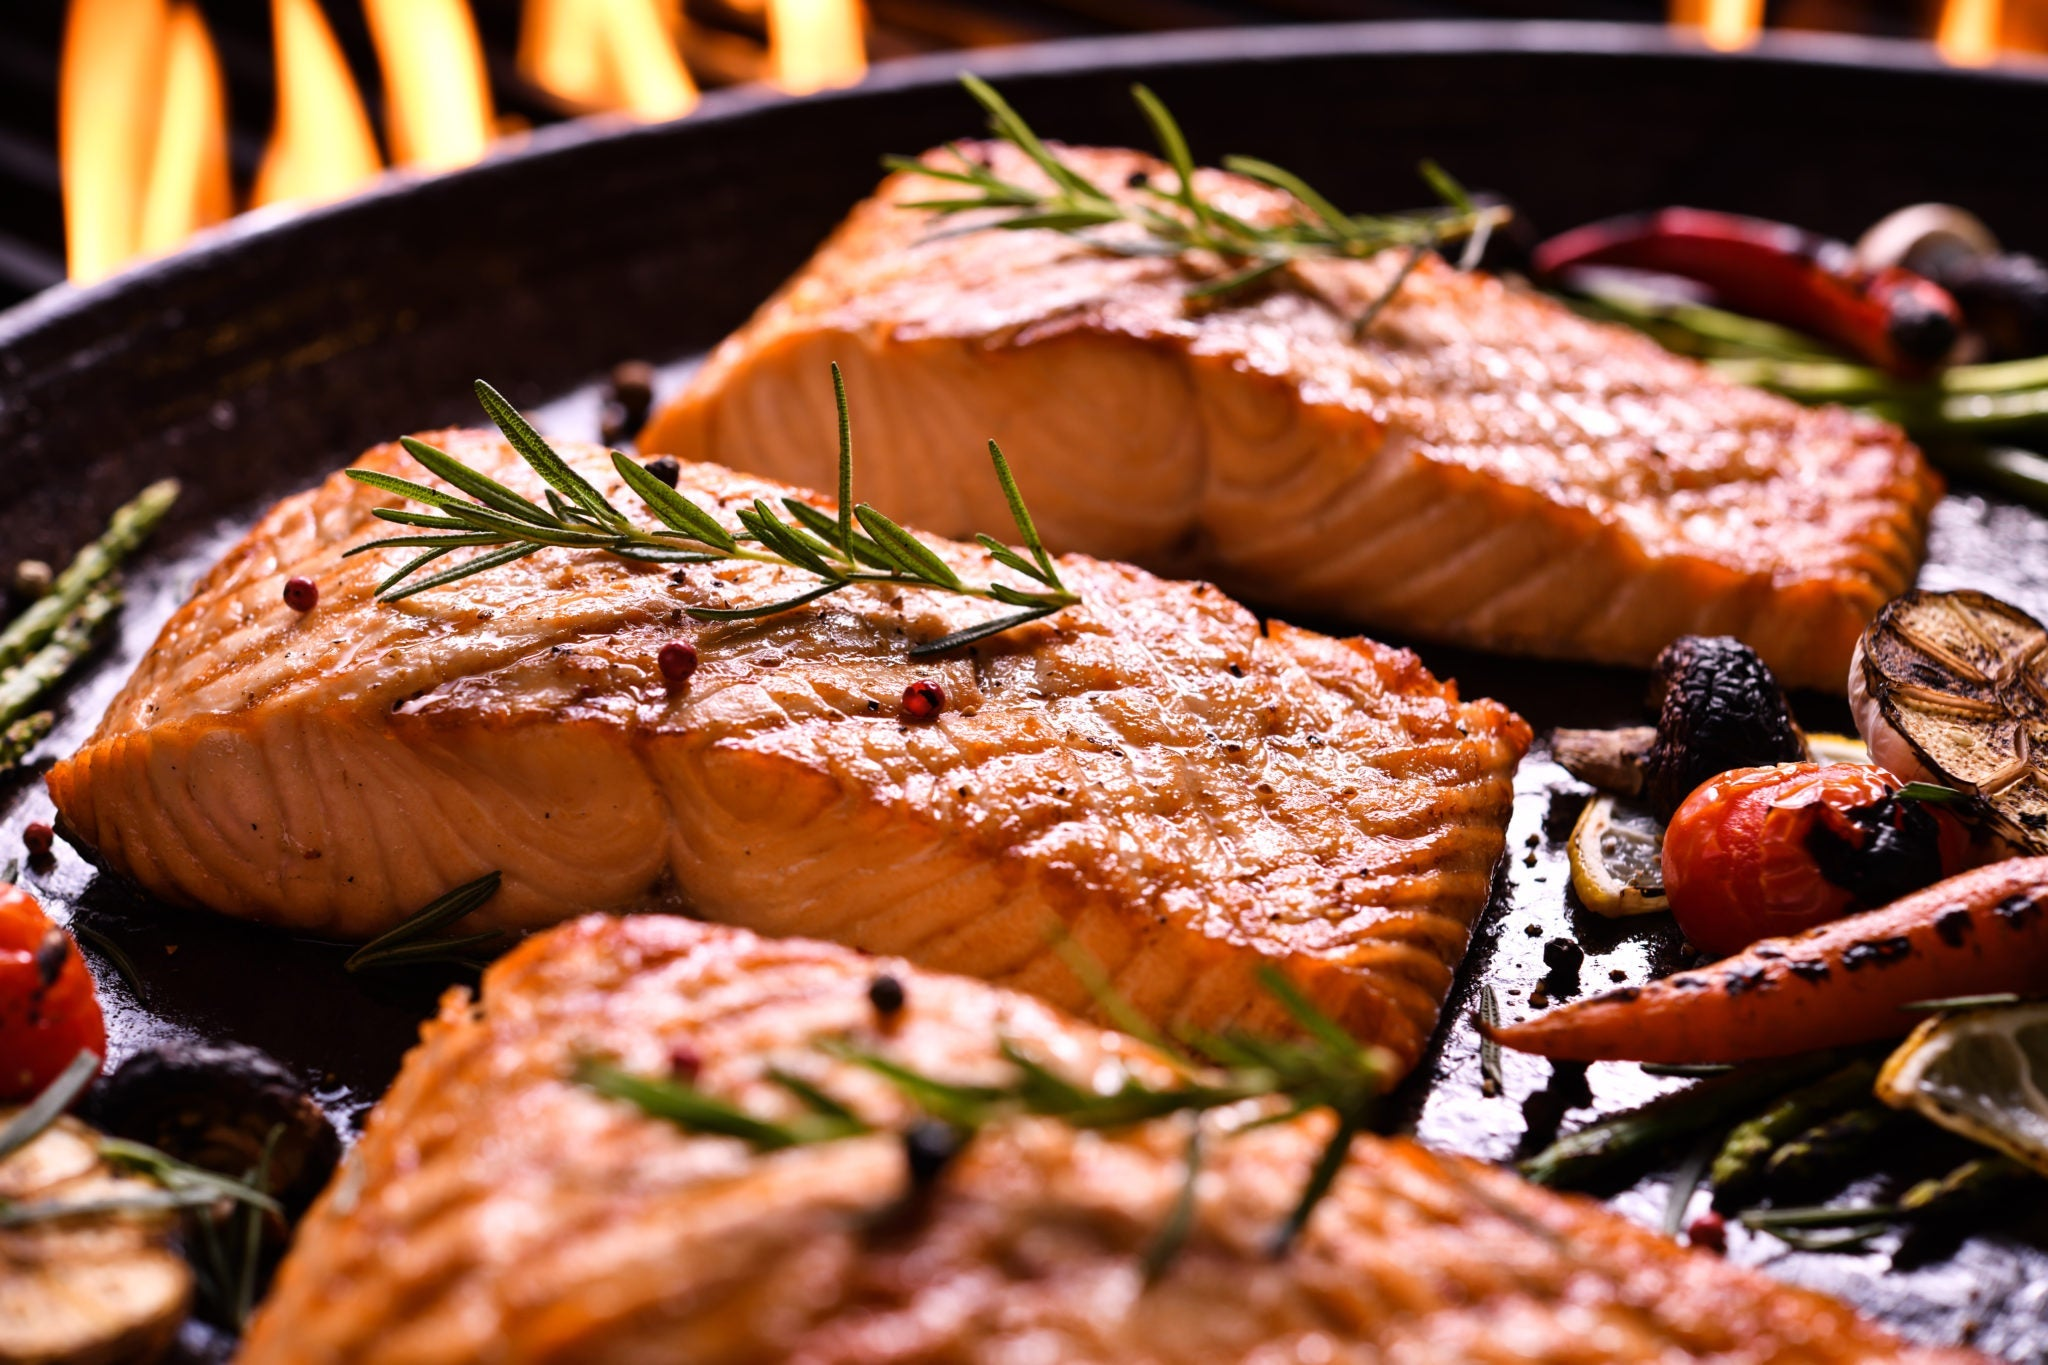

 The image shows a plate of grilled salmon fillets. Each piece of fish is topped with herbs, which appears to be rosemary and thyme, and there are vegetables like cherry tomatoes around them. In the background, there's a fireplace, suggesting that this might be a setting for a cozy meal or a social gathering. The salmon has a golden-brown crust, indicating it has been cooked on a grill. 


In [41]:
display_image(file_path)
print(image_result)

In [ ]:
from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnableMap
from langchain.memory import ConversationBufferMemory
from vector import retriever
from PIL import Image

model = OllamaLLM(model="llava")

# Prompt template
template = """
You are an expert in answering questions about foods and their nutrition. For every identified food, provide the ids.

Conversation history:
{history}

Here are the nutritional information of some foods: {details}

Here is the description of the image. When asked anything about an image : {image_result}

Here is the question to answer: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# Memory setup
memory = ConversationBufferMemory(memory_key="history", input_key="question", return_messages=False)

# chain = prompt | model # prompt will be passed automatically to the model
# changed when  ConversationBufferMemory was introduced whcih was built to handle only one user input
chain = (
    RunnableMap({
        "question": lambda x: x["question"],
        "image_result": lambda x: retriever.invoke(x["image_result"]),
        "details": lambda x: retriever.invoke(x["question"]),
        "history": lambda x: memory.load_memory_variables(x)["history"]
    })
    | prompt
    | model
    | RunnableLambda(lambda res: {"response": res})  # Wrap output for clean access
)

while True:
    print("\n\n-------------------------------")
    question = input("Ask your question (q to quit): ")
    print("\n\n")
    if question == "q":
        break

    #result = chain.invoke({"question": question})
    details = retriever.invoke(question)
    #image_result = retriever.invoke(image_result)
    result = chain.invoke({"details": details, "question": image_result+question, "image_result": image_result, })
    memory.save_context({"question": question}, {"response": result["response"]})
    print(result["response"])




-------------------------------


Ask your question (q to quit):  What is the protien content of the food item in the image?





 To determine the protein content of the grilled salmon fillets in the image, I would need access to the nutritional information for this specific type and preparation method of salmon. However, from the given nutritional information for cooked salmon, it is clear that a typical serving of cooked salmon contains approximately 25-30 grams of protein. The protein content of the herbs used as garnish would be negligible, so they are not relevant to the overall protein content of the dish. The cherry tomatoes and vegetables present around the salmon fillets do not provide any significant protein content either. Therefore, considering that the image shows a plate primarily consisting of grilled salmon fillets with a small amount of herbs and vegetables, it can be concluded that the protien content of this food item is approximately 25-30 grams per serving. 


-------------------------------
